### This notebook performs segmentation with a 3 Class U-Net, where the three classes are foreground, background and border.

In [1]:
# We import all our dependencies.
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../../')
from voidseg.models import Seg, SegConfig
import numpy as np
from csbdeep.utils import plot_history
from voidseg.utils.misc_utils import combine_train_test_data, shuffle_train_data, augment_data
from voidseg.utils.seg_utils import *
from voidseg.utils.compute_precision_threshold import compute_threshold, precision
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from scipy import ndimage
import tensorflow as tf
import keras.backend as K
import urllib
import os
import zipfile

Using TensorFlow backend.


### Download BBBC004 data.

This data is available from the Broad Bioimage Benchmark Collection linked [here](https://data.broadinstitute.org/bbbc/BBBC004/)  and consists of synthetic nuclei images. Since the data is synthetic, perfect GT labels are available by construction. Here we use only those images which have been generated with an overlap probability of 0. We extracted 880 image patches (of size 128 × 128) from the training set and added Gaussian noise with mean 0 and sigma = 150 (n150) and 200 (n200). This notebook shows results for n200 images.

In [2]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')

# check if data has been downloaded already
zipPath="data/BBBC004.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://owncloud.mpi-cbg.de/index.php/s/zlgcEjqBbK3jcEs/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

The downloaded data is in `npz` format and the cell below extracts the training, validation and test data as numpy arrays

In [3]:
trainval_data =  np.load('data/BBBC/train_data/bbbc004_TrainVal200.npz')
test_data =  np.load('data/BBBC/test_data/bbbc004_Test200.npz', allow_pickle=True)
train_images = trainval_data['X_train']
val_images = trainval_data['X_val']
test_images = test_data['X_test']

train_masks = trainval_data['Y_train']
val_masks = trainval_data['Y_val']
test_masks = test_data['Y_test']

In [4]:
print("Shape of train_images: ", train_images.shape, ", Shape of train_masks: ", train_masks.shape)
print("Shape of val_images: ", val_images.shape, ", Shape of val_masks: ", val_masks.shape)
print("Shape of test_images: ", test_images.shape, ", Shape of test_masks: ", test_masks.shape)

Shape of train_images:  (748, 128, 128) , Shape of train_masks:  (748, 128, 128)
Shape of val_images:  (132, 128, 128) , Shape of val_masks:  (132, 128, 128)
Shape of test_images:  (220, 128, 128) , Shape of test_masks:  (220, 128, 128)


### Data preparation for segmentation step

Next, we normalize all raw data with the mean and std (standard deviation) of the raw `train_images`. Then, we shuffle the raw training images and the correponding Ground Truth (GT). Lastly, we fractionate the training pairs of raw images and corresponding GT to realize the case where not enough annotated, training data is available. For this fractionation, please specify `fraction` parameter below. It should be between 0 (exclusive) and 100 (inclusive).

In [5]:
fraction = 2 # Fraction of annotated GT and raw image pairs to use during training. 
random_seed = 1 # Seed to shuffle training data (annotated GT and raw image pairs).


assert 0 <fraction<= 100, "Fraction should be between 0 and 100"
mean, std = np.mean(train_images), np.std(train_images)

X_normalized = normalize(train_images, mean, std)
X_val_normalized = normalize(val_images, mean, std)
X_test_normalized = normalize(test_images, mean, std)

X_shuffled, Y_shuffled = shuffle_train_data(X_normalized, train_masks, random_seed = random_seed)
X_frac, Y_frac = fractionate_train_data(X_shuffled, Y_shuffled, fraction = fraction)
print("Training Data \n..................")
X, Y_train_masks = augment_data(X_frac, Y_frac)
print("\n")
print("Validation Data \n..................")
X_val, Y_val_masks = augment_data(X_val_normalized, val_masks)

Training Data 
..................
Raw image size after augmentation (120, 128, 128)
Mask size after augmentation (120, 128, 128)


Validation Data 
..................
Raw image size after augmentation (1056, 128, 128)
Mask size after augmentation (1056, 128, 128)


Next, we do a one-hot encoding of training and validation labels for training a 3-class U-Net. One-hot encoding will extract three channels from each labelled image, where the channels correspond to background, foreground and border.

In [6]:
X = X[...,np.newaxis]
Y = convert_to_oneHot(Y_train_masks)
X_val = X_val[...,np.newaxis]
Y_val = convert_to_oneHot(Y_val_masks)
print("Shape of train images: ", X.shape, ", Shape of train masks: ", Y.shape)
print("Shape of validation images: ", X_val.shape, ", Shape of validation masks: ", Y_val.shape)

Shape of train images:  (120, 128, 128, 1) , Shape of train masks:  (120, 128, 128, 3)
Shape of validation images:  (1056, 128, 128, 1) , Shape of validation masks:  (1056, 128, 128, 3)


Let's look at one of our validation patches.

Text(0.5, 1.0, '1-hot encoded border')

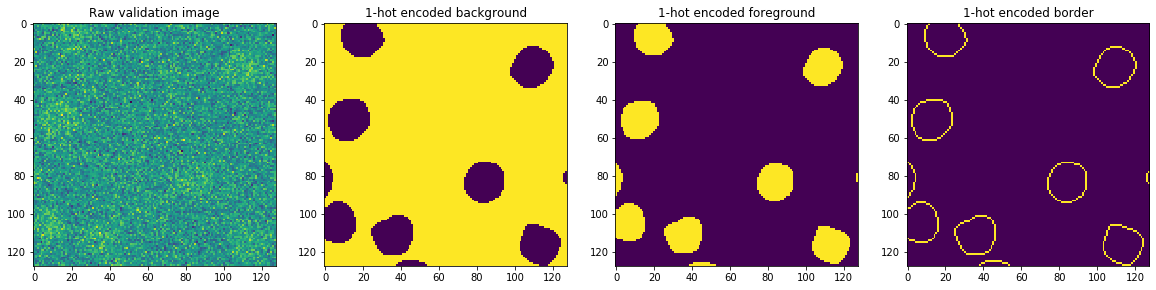

In [7]:
sl=0
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(X_val[sl,...,0])
plt.title('Raw validation image')
plt.subplot(1,4,2)
plt.imshow(Y_val[sl,...,0])
plt.title('1-hot encoded background')
plt.subplot(1,4,3)
plt.imshow(Y_val[sl,...,1])
plt.title('1-hot encoded foreground')
plt.subplot(1,4,4)
plt.imshow(Y_val[sl,...,2])
plt.title('1-hot encoded border')

### Configure Segmentation Network

The data preparation for segmentation is now done. Next, we configure a segmentation network by specifying `SegConfig` parameters. For example, one can increase `train_epochs` to get even better results at the expense of a longer computation. (This holds usually true for a large `fraction`.)

In [8]:
relative_weights = [1.0,1.0,5.0] # Relative weight of background, foreground and border class for training

config = SegConfig(X, unet_kern_size=3, relative_weights = relative_weights,
                   train_steps_per_epoch=400, train_epochs=3, train_loss='seg', batch_norm=True, 
                   train_batch_size=128, unet_n_first = 32, unet_n_depth=3)


# Let's look at the parameters stored in the config-object.
# a name used to identify the model
model_name = 'seg_baseline'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
seg_model = Seg(config, model_name, basedir=basedir)
vars(config)

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 3,
 'train_loss': 'seg',
 'unet_n_depth': 3,
 'relative_weights': [1.0, 1.0, 5.0],
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'probabilistic': False,
 'unet_residual': False,
 'unet_input_shape': (None, None, 1),
 'train_epochs': 3,
 'train_steps_per_epoch': 400,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': False,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True}

Now, we begin training the model for segmentation.

In [9]:
seg_model.train(X, Y, (X_val, Y_val))

Epoch 1/3
400/400 [==============================] - 129s 322ms/step - loss: 0.1169 - seg_crossentropy: 0.1169 - val_loss: 0.3747 - val_seg_crossentropy: 0.3747
Epoch 2/3
400/400 [==============================] - 123s 308ms/step - loss: 0.0174 - seg_crossentropy: 0.0174 - val_loss: 0.5331 - val_seg_crossentropy: 0.5331
Epoch 3/3
400/400 [==============================] - 124s 311ms/step - loss: 0.0051 - seg_crossentropy: 0.0051 - val_loss: 0.6381 - val_seg_crossentropy: 0.6381

Loading network weights from 'weights_best.h5'.


### Computing the best threshold on validation images (to maximize Average Precision score). The threshold so obtained will be used to get hard masks from probability images to be predicted on test images.

In [10]:
threshold=seg_model.optimize_thresholds(X_val_normalized.astype(np.float32), val_masks)

Computing best threshold: 


Precision-Score for threshold = 0.10 is 0.6716
Precision-Score for threshold = 0.15 is 0.6868
Precision-Score for threshold = 0.20 is 0.7039
Precision-Score for threshold = 0.25 is 0.7054
Precision-Score for threshold = 0.30 is 0.7158
Precision-Score for threshold = 0.35 is 0.7201
Precision-Score for threshold = 0.40 is 0.7229
Precision-Score for threshold = 0.45 is 0.7249
Precision-Score for threshold = 0.50 is 0.7292
Precision-Score for threshold = 0.55 is 0.7300
Precision-Score for threshold = 0.60 is 0.7296
Precision-Score for threshold = 0.65 is 0.7343
Precision-Score for threshold = 0.70 is 0.7317
Precision-Score for threshold = 0.75 is 0.7280
Precision-Score for threshold = 0.80 is 0.7344
Precision-Score for threshold = 0.85 is 0.7346
Precision-Score for threshold = 0.90 is 0.7294
Precision-Score for threshold = 0.95 is 0.6959
Precision-Score for threshold = 1.00 is 0.0000



### Prediction on test images to get segmentation result

In [11]:
predicted_images, precision_result=seg_model.predict_label_masks(X_test_normalized, test_masks, threshold)
print("Average precision over all test images at IOU = 0.5: ", precision_result)

Average precision over all test images at IOU = 0.5:  0.7537640263776627


Text(0.5, 1.0, 'Ground Truth')

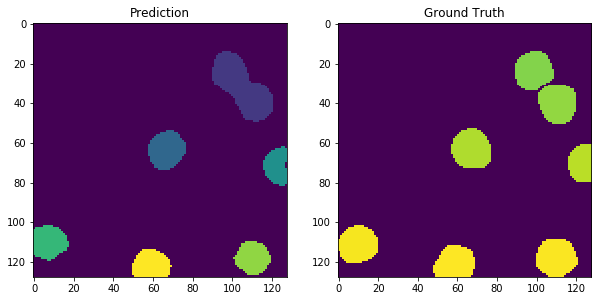

In [12]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(predicted_images[22])
plt.title('Prediction')
plt.subplot(1,2,2)
plt.imshow(test_masks[22])
plt.title('Ground Truth')